# Final Project
Group 4: Joshua Hummell, Jiho Kim, Scott Reed

Elon Musk recently decided to purchase Twitter. After considering other final projects, we decided to do a combined Network and Text analysis on Elons Musk’s tweets for directly after announcing he was going to buy Twitter. In this way, we can see the networks that support Elon or disapprove of Elon.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
import pandas as pd
import numpy as np
import scipy
import random
import re

import sys
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from textblob import TextBlob
import nltk
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer


pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'wordcloud'

## Step One: getting the tweets 
We have it in Markdown now becuase we already ran it. So for consistency, we ran it once and it was too large to be hosted on Github so we had to store it on my personal website, as you will see in Step 2

import nest_asyncio
nest_asyncio.apply()
import twint


##### Configure
c = twint.Config()
c.Search = ["#ElonMuskTwitter", "#ElonMuskBuyTwitter"]
c.Store_csv = True
c.Since = '2022-04-14'
c.Limit = 10000
c.Output = 'elon-tweets.csv'

##### Run
twint.run.Search(c)

In [2]:
## Step 2: Data Exploration

In [2]:
df = pd.read_table("https://hummelljoshua.me/elon-tweets.csv",
                encoding='utf-8', 
                header=0, 
                sep = ",", 
                usecols = ['username','date','time', 'tweet', 'likes_count', 'replies_count','retweets_count'])

Let's first take a look at our data

In [3]:
df.head()

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,2022-04-22,14:37:08,fariha173_,@Moon50097307 @WhaleChart @Marvin_Inu @elonmus...,0,0,0
1,2022-04-22,14:37:07,boonefollow187,#PMSUpToSomethingSZN @PatMcAfeeShow is teaming...,0,0,0
2,2022-04-22,14:37:07,utopia_hippie,@Feelthe86085074 @AtNecks @ShaunKraisman @Gabr...,0,0,0
3,2022-04-22,14:37:07,fleecegeek,High 👋 @elonmusk ... only you buying Twitter c...,0,0,0
4,2022-04-22,14:37:07,letsunitegld,@vico_dbn 👍🏿and Elon musk is the African of Am...,0,0,0


Now let's make sure we know all the columns and get some stats on the data

In [4]:
df.describe()

,replies_count,retweets_count,likes_count
count,365235.000000,365235.000000,365235.000000
mean,2.527827,4.015894,40.609104
std,180.866993,261.118664,2976.677625
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000
max,63334.000000,65412.000000,714555.000000


Let's take a closer look at likes_Count because it shows a huge std devitation compared to the mean, meanign there are quite a few people who get a small amount of likes and a few people who get many likes

(array([547.,  12.,   5.,   8.,   4.,   2.,   1.,   0.,   1.,   2.]),
 array([  1005.,  72360., 143715., 215070., 286425., 357780., 429135.,
        500490., 571845., 643200., 714555.]),
 <BarContainer object of 10 artists>)

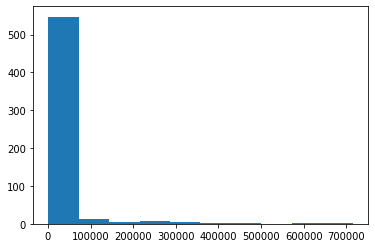

In [6]:
plt.hist(df['likes_count'].loc[df['likes_count'] > 1000], bins=10)

In [7]:
print("There are", len(df['likes_count'].loc[df['likes_count'] < 100]), "people who got less than 100 likes")
print("There are", len(df['likes_count'].loc[df['likes_count'] > 100]), "people who got more than 100 likes and", len(df['likes_count'].loc[df['likes_count'] > 1000]), "who got more than 1000")

There are 362206 people who got less than 100 likes
There are 3001 people who got more than 100 likes and 582 who got more than 1000


(array([297342.,  33190.,  10596.,   5252.,   3009.]),
 array([0. , 1.8, 3.6, 5.4, 7.2, 9. ]),
 <BarContainer object of 5 artists>)

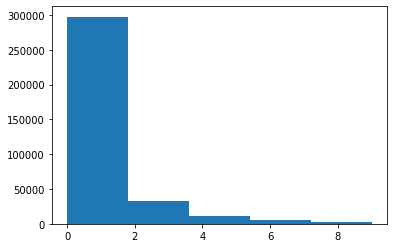

In [8]:
plt.hist(df['likes_count'].loc[df['likes_count'] < 10], bins=5)

Let's check retweets as well

(array([348988.,   7408.,   2427.,   1230.,    808.]),
 array([0. , 1.8, 3.6, 5.4, 7.2, 9. ]),
 <BarContainer object of 5 artists>)

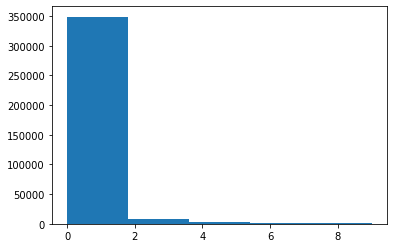

In [9]:
plt.hist(df['retweets_count'].loc[df['retweets_count'] < 10], bins=5)

(array([135.,  12.,   2.,   3.,   2.]),
 array([ 1003. , 13884.8, 26766.6, 39648.4, 52530.2, 65412. ]),
 <BarContainer object of 5 artists>)

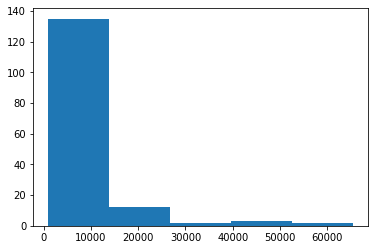

In [10]:
plt.hist(df['retweets_count'].loc[df['retweets_count'] > 1000], bins=5)

In [11]:
print("There are", len(df['retweets_count'].loc[df['retweets_count'] < 100]), "people who got less than 100 retweets")
print("There are", len(df['retweets_count'].loc[df['retweets_count'] > 100]), "people who got more than 100 retweets and", len(df['retweets_count'].loc[df['retweets_count'] > 1000]), "who got more than 1000")

There are 364431 people who got less than 100 retweets
There are 784 people who got more than 100 retweets and 154 who got more than 1000


In [12]:
print("There are", len(df['replies_count'].loc[df['replies_count'] < 100]), "people who got less than 100 replies")
print("There are", len(df['replies_count'].loc[df['replies_count'] > 100]), "people who got more than 100 replies and", len(df['replies_count'].loc[df['replies_count'] > 1000]), "who got more than 1000")

There are 364711 people who got less than 100 replies
There are 521 people who got more than 100 replies and 109 who got more than 1000


Interesting that there are less greater retweets than not. Let's see how we can match retweets with users as well as comments. 

## Step 3: Sentiment Analysis

In order to run the Sentiment analysis we are going to create new dataframe from the one above that classifies each tweet on % of neutralilty, positivity, and negativity, and based on the % we will classify it as one of them. 

In [7]:
positive = int(0)
negative = int(0)
neutral = int(0)
polarity = int(0)
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

In [8]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

In [9]:
noOfTweet = len(df['tweet'])

In [10]:
for tweet in df['tweet']:
    
    tweet_list.append(tweet)
    analysis = TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet)
        positive += 1

    elif pos == neg:
        neutral_list.append(tweet)
        neutral += 1

NameError: name 'TextBlob' is not defined

In [11]:
df_n = pd.DataFrame(negative_list, columns =['tweet'])
df_n['cat'] = "Neg"
df_p = pd.DataFrame(positive_list, columns =['tweet'])
df_p['cat'] = "Pos"
df_ne = pd.DataFrame(neutral_list, columns =['tweet'])
df_ne['cat'] = "Neu"

In [12]:
df_n = df_n.append([df_p, df_ne], ignore_index=True, sort=False)

Now we have populated the empty lists, we can merge it with our data set.

The below code has been turned into markdown becuase it is machine heavy to run. So I took the liberty of running it on my own and saving the file, where it was just downloaded above. 

In [13]:
df_f = pd.read_table("https://hummelljoshua.me/sentiment.tsv",
                header=0, 
                sep = "\t")

df_f = df.merge(df_n[['cat','tweet']], how='left', on='tweet')

df_f['text'] = df_f['tweet']

remove_rt = lambda x: re.sub('RT'," ",x)
rt = lambda x: re.sub("((@)\w*(?=\s))"," ",x)
hasht = lambda x: re.sub("((#)\w*(?=\s))"," ",x)
dolla =  lambda x: re.sub("((\$)\w*(?=\s))"," ",x)
df_f["text"] = df_f.text.map(remove_rt).map(rt).map(hasht).map(dolla)
df_f["text"] = df_f.text.str.lower()
df_f.head(10)

df_f[['polarity', 'subjectivity']] = df_f['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))


#Calculating Negative, Positive, Neutral and Compound values
import time
n = len(df_f)

t0 = time.time()

for index, row in df_f['text'].iteritems():
    t1 = time.time()
    print("Processing file {} ({}%)".format(index, 100*index//n), end="")
    
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if neg > pos:
        df_f.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_f.loc[index, 'sentiment'] = "positive"
    else:
        df_f.loc[index, 'sentiment'] = "neutral"
        
    df_f.loc[index, 'neg'] = neg
    df_f.loc[index, 'neu'] = neu
    df_f.loc[index, 'pos'] = pos
    df_f.loc[index, 'compound'] = comp
    t2 = time.time()
    print(" {}s (total: {}s)".format(round(t2-t1, 2), round(t2-t0,2)))
df_f.head(10)

In [14]:
tw_list_negative = df_f[df_f["sentiment"]=="negative"]
tw_list_positive = df_f[df_f["sentiment"]=="positive"]
tw_list_neutral = df_f[df_f["sentiment"]=="neutral"]

In [15]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(df_f,"sentiment")

,Total,Percentage
neutral,337049,52.33
positive,187543,29.12
negative,119437,18.55


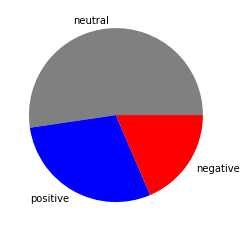

In [16]:
# create data for Pie Chart
pichart = count_values_in_column(df_f,"sentiment")

mylabels = ['neutral', 'positive', 'negative']
mycolors = ["gray", "blue", "red"]
 
plt.pie(pichart['Percentage'], labels = mylabels, colors = mycolors)
plt.show() 

In [108]:
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="black",
    mask = mask,
    max_words=1000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


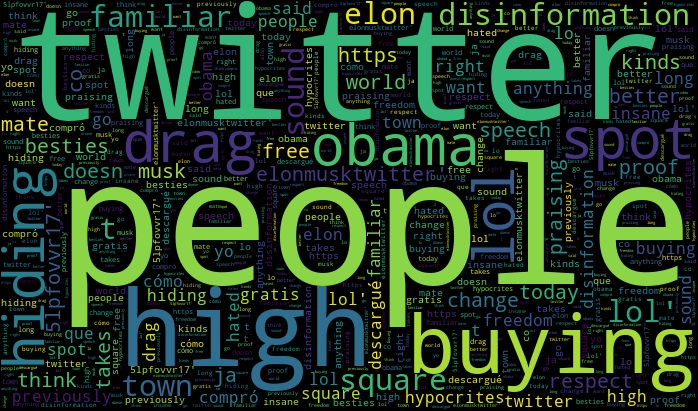

In [109]:
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


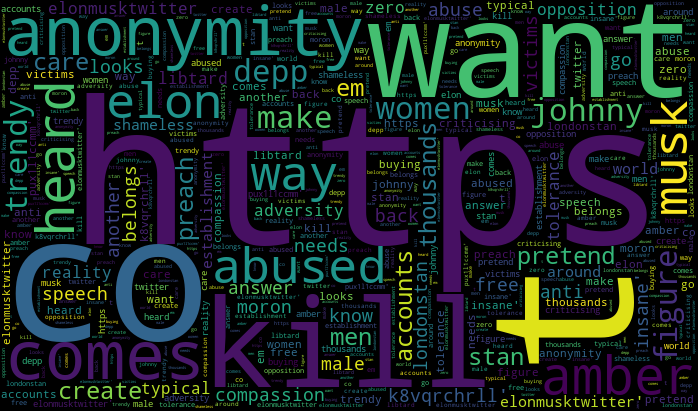

In [110]:
create_wordcloud(tw_list_negative["text"].values)

How concerned are people with Elon taking over Twitter?

We can see that 52% of people do not care, 29% are happy, and 18% are alarmed. However, since the tweets gathered were from the intial days of Elon's announcement, people thought he might be joking, or just spreading rumors as he normally does. Now that he is getting it, it would be interesting to see if sentiments change. 

## Step 4: Network Analysis

This section will go with the last, in that we want to look at the networks surrounding the Positive and Negative Sentiment to see how the sentiment is distributed. 

In [17]:
# create a networkx directed graph
G_retweet = nx.DiGraph()
G_mention = nx.DiGraph()

In [18]:
for r in df_f.iterrows():
    author = r[1]['username']
    author = f'@{author}'
  
    text = r[1]['tweet']
  
    try:
        timestamp = pd.to_datetime(r[1]['date'] +' ' +r[1]['time'])
    except:
        continue
        
    #cat = r[1]['cat']
 
    # use regular expressions to extract retweets and mentions
    retweets = set(re.findall(r"RT @(\w+)", text))
    mentions = set(re.findall(r"@(\w+)", text))
    
    

    # remove duplicated users
    for r in retweets:
        if r in mentions:
            mentions.remove(r)

    # add the users if there are any mentioned in the text.
    has_users = len(retweets) + len(mentions) > 0
    if has_users:
        for u in retweets:
            u = f'@{u}'
            G_retweet.add_edge(author, u, Timestamp=timestamp)

        for u in mentions:
            u = f'@{u}'
            G_mention.add_edge(author, u, Timestamp=timestamp)

In [19]:
author = df['username'][0]
author = f'@{author}'
  
text = df['tweet'][0]

timestamp = pd.to_datetime(df['date'] +' ' +  df['time'])
retweets = set(re.findall(r"RT @(\w+)", text))
mentions = set(re.findall(r"@(\w+)", text))


print(author, retweets,mentions)
print(len(retweets))

@fariha173_ set() {'Marvin_Inu', 'elonmusk', 'Moon50097307', 'WhaleChart'}
0


In [21]:
df['username'][0]

'fariha173_'

In [22]:
df_retweet = nx.to_pandas_edgelist(G_retweet)

 
df_mention = nx.to_pandas_edgelist(G_mention)


In [23]:
df_mention

,source,target,Timestamp
0,@fariha173_,@Marvin_Inu,2022-04-22 14:37:08
1,@fariha173_,@elonmusk,2022-04-22 14:37:08
2,@fariha173_,@Moon50097307,2022-04-22 14:37:08
3,@fariha173_,@WhaleChart,2022-04-22 14:37:08
4,@elonmusk,@PPathole,2022-04-22 04:25:58
...,...,...,...
471671,@nolietees,@DonaldJTrumpJr,2022-04-27 11:08:34
471672,@nolietees,@glennbeck,2022-04-27 11:08:34
471673,@nolietees,@laurenboebert,2022-04-27 11:08:34
471674,@nolietees,@TomiLahren,2022-04-27 11:08:34


In [ ]:
df_retweet.to_csv('retweet.csv', index=False)
df_mention.to_csv('mention.csv', index=False)